Complete the exercises below For **Assignment #4**.

Use **Markdown** cells for the non-code answers.

In this assignment we will work with the data underlying the *FiveThirtyEight* article ["Higher Rates Of Hate Crimes Are Tied To Income Inequality"](https://fivethirtyeight.com/features/higher-rates-of-hate-crimes-are-tied-to-income-inequality/).

Load the `tidymodels`, `readr`, and `moderndive` packages in the cell below.

In [4]:
# Load packages
library(tidymodels)
library(readr)
library(moderndive)
library(ggplot2)

We can read the data from a **CSV file** at the following URL: [http://bit.ly/2ItxYg3](http://bit.ly/2ItxYg3).

Use the `read_csv` function to read the data into our R session. Call the new table `hate_crimes`.

In [6]:
hate_crimes <- read_csv('http://bit.ly/2ItxYg3')
head(hate_crimes)

Rows: 51 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): state, median_house_inc, trump_support, unemployment, urbanization
dbl (4): share_pop_metro, hs, hate_crimes, income

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


state,median_house_inc,share_pop_metro,hs,hate_crimes,trump_support,unemployment,urbanization,income
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
New Mexico,low,0.69,83,0.295,low,high,low,46686
Maine,low,0.54,90,0.616,low,low,low,51710
New York,low,0.94,85,0.351,low,low,high,54310
Illinois,low,0.90,86,0.195,low,high,high,54916
Delaware,high,0.90,87,0.323,low,low,high,57522
Rhode Island,high,1.00,85,0.095,low,high,high,58633


Next, let’s add the high-school degree variable into the mix by creating a scatterplot showing:

- Income on the y-axis (this is the `income` variable)
- Percent of adults 25 or older with a high school degree on the x-axis (this is the `hs` variable)
- The points colored by level of urbanization in a region (this is the variable `urbanization`)


**In addition, add a line of best fit (regression line) for each level of the variable urbanization (one for “low”, one for “high”).**

*Add the regression lines to the plot using the `geom_parallel_slopes` function from the `moderndive` package. This function will draw the regression lines based on fitting a regression model with parallel slopes (i.e., with no interaction between `hs` and `urbanization`).*

Warning message:
“Removed 3 rows containing non-finite outside the scale range
(`stat_parallel_slopes()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”


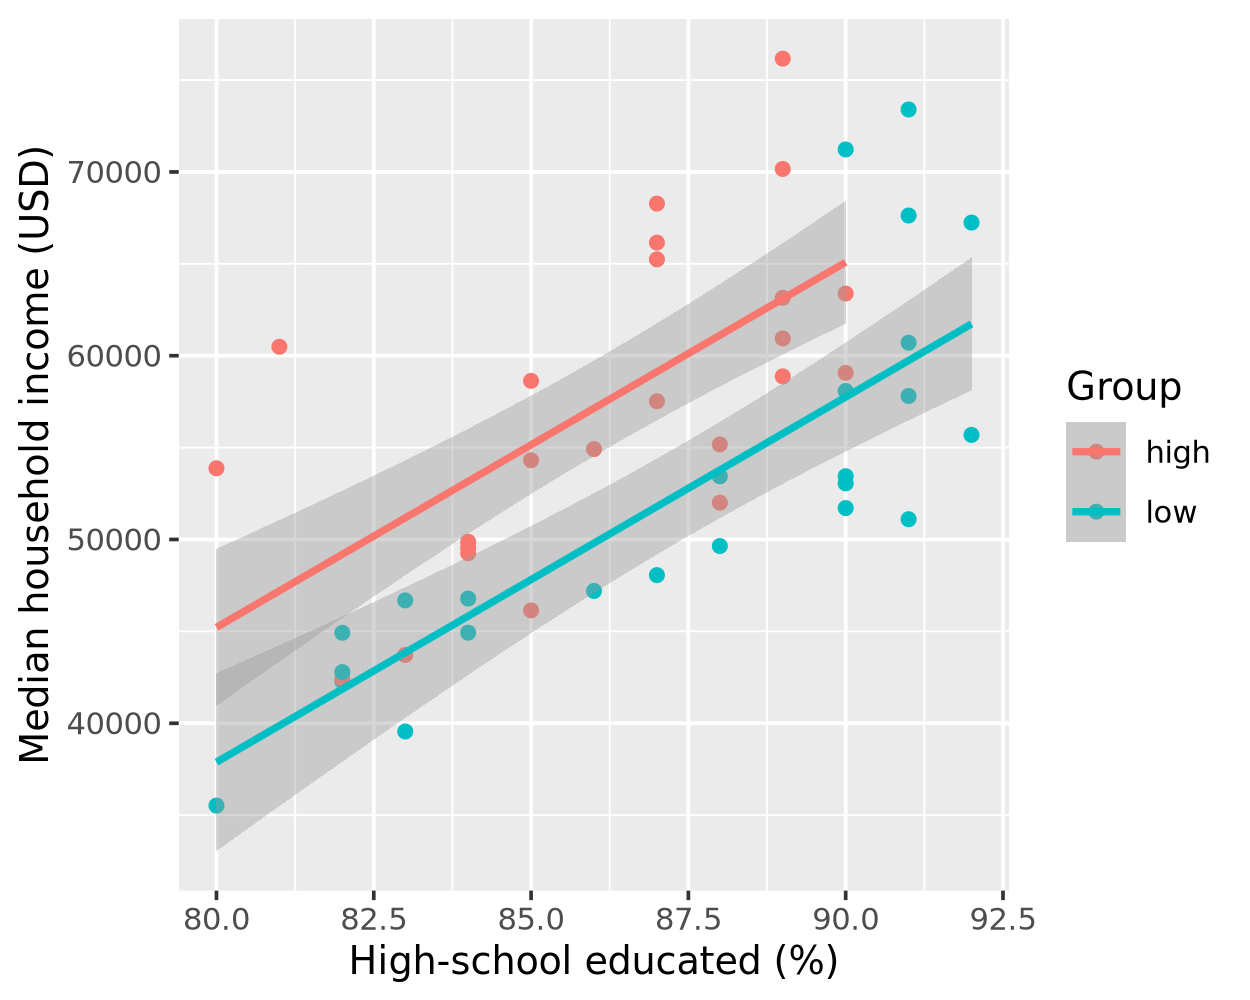

In [7]:


# Scatterplot of income vs hs with separate regression lines for low/high urbanization
ggplot(hate_crimes, aes(x = hs, y = income, color = urbanization)) +
  geom_point() +
  geom_parallel_slopes() +
  labs(x = "High-school educated (%)",
       y = "Median household income (USD)",
       color = "Group")


❓Which regression line (high urbanization or low urbanization) appears to have the larger intercept?

**Answer:**

The "high" urbanization group appears to have the larger intercept. This means that high urbanization can be predicted to have a higher median household income. 

Now let’s create a second scatterplot using the same variables, but this time draw the regression lines using `geom_smooth(method = "lm")`, which will allow for separate, non-parallel slopes for each urbanization group. 

**Code your scatter plot in the cell below.**

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 3 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”


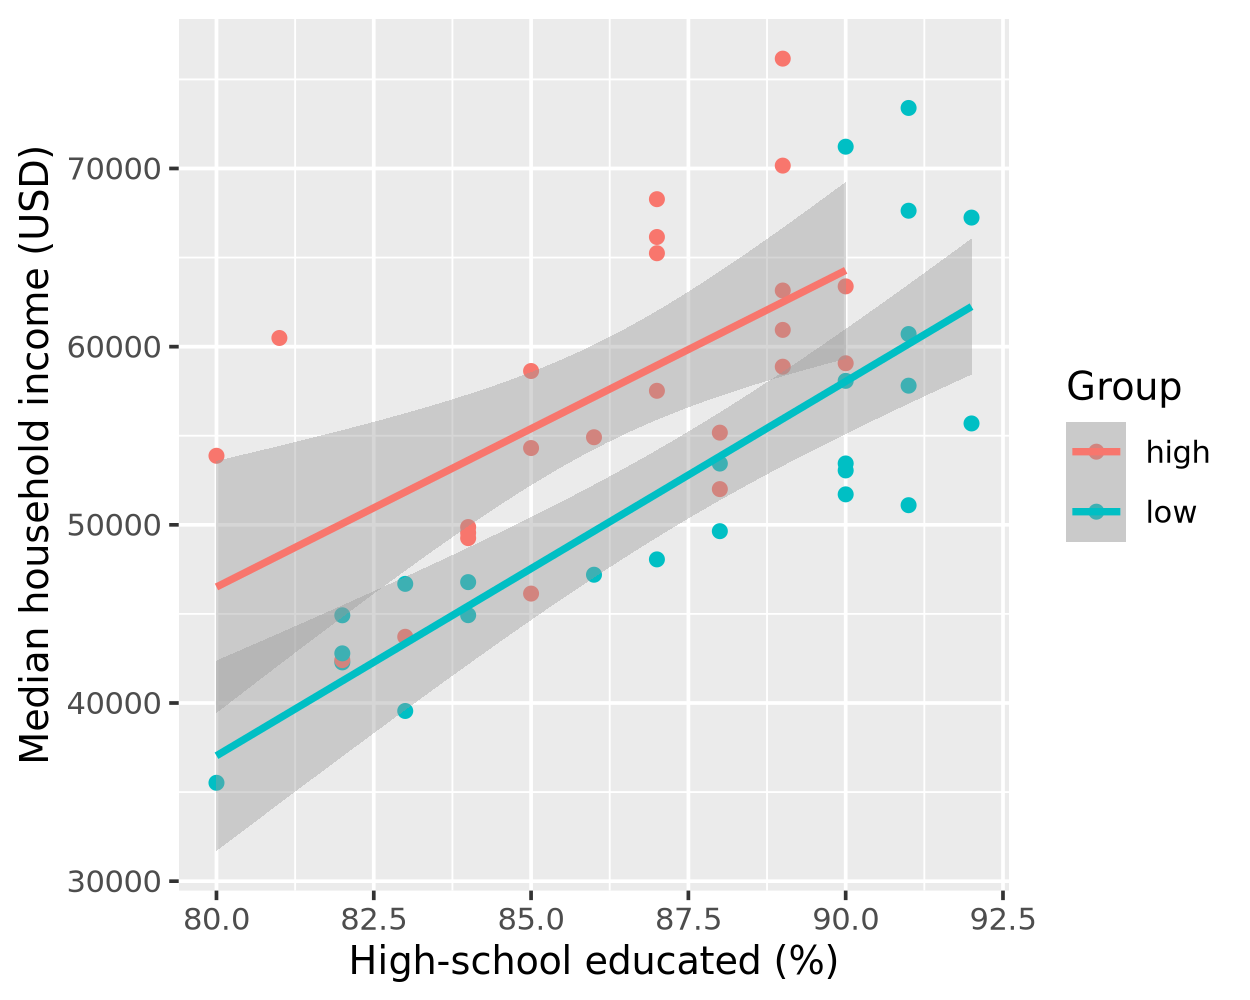

In [8]:
# Scatterplot of income vs hs with separate regression lines for low/high urbanization
ggplot(hate_crimes, aes(x = hs, y = income, color = urbanization)) +
  geom_point() +
  geom_smooth(method = "lm") +
  labs(x = "High-school educated (%)",
       y = "Median household income (USD)",
       color = "Group")

❓Based on visually comparing the two models shown above, do you think it would be best to run a “parallel slopes” model (i.e. a model that estimates one shared slope for the two levels of urbanization), or a more complex “interaction model” (i.e. a model that estimates a separate slope for the two levels of urbanization)?

**Answer:**

I would predict that it is best to run an "interaction model" since high and low urbanization are differnt categories and you would be ignoring thier differences if you are constraining the slope to be the same. While the line slopes appear to be quite similar in the second graph (meaning "parallel slopes" wouldn't be a bad model), there are subtle differences between the lines that might be important to analysis. 

Fit the following two regression models that examine the relationship between household `income` (as response variable), and high-school education (`hs`) and `urbanization` as explanatory variables:

1. A parallel slopes model (i.e., no interaction between `hs` and `urbanization`). ❗️Save the data recipe and model under the variables `ps_rec` and `ps_mod`, respectively. 
1. A non-parallel slopes model (i.e., allow `hs` and `urbanization` to interact in your model). ❗️Save the data recipe and model under the variable: `nps_rec` and `nps_mod`, respectively.

**Code you your models in the cell below.**

In [9]:
# parallel slopes model

ps_rec = recipe(income ~ hs + urbanization, data = hate_crimes) |> 
    step_naomit(everything()) |>   # remove missing values
    step_dummy(urbanization) |>    # dummy encode the urbanization variable
    prep()                         # run the recipe on the training data provided

mod = linear_reg() |> set_engine('lm')

ps_mod = mod |> fit(income ~ ., juice(ps_rec))

ps_mod

parsnip model object


Call:
stats::lm(formula = income ~ ., data = data)

Coefficients:
     (Intercept)                hs  urbanization_low  
         -113725              1987             -7333  


In [10]:
nps_rec = recipe(income ~ hs + urbanization, data = hate_crimes) |>
  step_naomit(everything()) |>
  step_dummy(urbanization) |>
  step_interact(~ starts_with("urbanization"):hs) |> # creates interaction between hs and urbanization dummy columns
  prep()

nps_mod = mod |> fit(income ~ ., juice(nps_rec)) # allows the slope of hs to differ by urbanization category

nps_mod


parsnip model object


Call:
stats::lm(formula = income ~ ., data = data)

Coefficients:
          (Intercept)                     hs       urbanization_low  
               -95647                   1777                 -35394  
urbanization_low_x_hs  
                  324  


The following code creates a table of your model predictions over the training data. Calculate the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) (R<sup>2</sup>) for each model:

```r
rbind(
    augment(ps_mod, juice(ps_rec)) |> select(income, .pred, .resid) |> mutate(model = "parallel_slopes"),
    augment(nps_mod, juice(nps_rec)) |> select(income, .pred, .resid) |> mutate(model = "interaction")
)
```

1. Group rows by the `model` variable (use the `group_by` function).
1. Calculate the variance of income over the variance of your predictions for each model using the "grouped" data from the step above (use `summarize(r_squared = var(.pred) / var(income))`).

In [13]:
preds <- rbind(
  augment(ps_mod, juice(ps_rec)) |> 
    select(income, .pred, .resid) |> 
    mutate(model = "parallel_slopes"),
  augment(nps_mod, juice(nps_rec)) |> 
    select(income, .pred, .resid) |> 
    mutate(model = "interaction")
)

# R squared using grouped variance ratio
r2_by_group <- preds |>
  group_by(model) |>
  summarize(r_squared = var(.pred) / var(income), .groups = "drop")

r2_by_group



model,r_squared
<chr>,<dbl>
interaction,0.5746731
parallel_slopes,0.5716112


🎶 Note: you can also use the `glance` function with a model as input to find the coefficient of determination.

In [14]:
glance(ps_mod)

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.5716112,0.5525717,6325.667,30.02238,5.204241e-09,2,-486.6739,981.3479,988.8327,1800633086,45,48


❓Compare the adjusted proportion of variance accounted for in each model. Based on this comparison, which model do you prefer? Why? 

**Answer:**

While the interaction model has a slight bump in raw fit, after you account for the extra term the adjusted R^2 value is actually lower than the parallel model. This makes the parallel model the better option which contradicts the difficult prediction I had to make earlier based purely on the visuals of the graph. The interaction model has needless compelxity and is penalized for it. 

❓Using your preferred model, based on your regression model parameters (and the data visualizations), is `income` greater in states that have lower or higher levels of `urbanization`? By how much?

**Hint:** use the `tidy` function with your model as input to access the parameters in a nice table.

**Answer:**

In [15]:
tidy(ps_mod)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-113725.193,23552.9187,-4.828497,1.624694e-05
hs,1986.794,272.9303,7.279490,3.930730e-09
urbanization_low,-7333.326,1857.6592,-3.947616,2.744526e-04


The states with higher urbanization have about $7300 more income based on this model if the high-school education variable is held constant. This number is taken from the `estimate` column of the table for the row `urbaization_low`. 

❓For every one percentage point increase of high-school educated adults in a state (`hs` variable), what is the associated average increase in `income`?

**Answer:**

For every one percentage point increase in high-school educated adults in a state there is an associated increase of $1986 in `income` based on the model. This value is taken from the table of parameters which clearly shows this. 